In [1]:
import gmsh
import numpy as np
import jax.numpy as jnp
from dctkit.mesh import util, simplex
from dctkit.math.opt import optctrl
from dctkit.apps.linear_elasticity import LinearElasticity
import dctkit.dec.cochain as C
import dctkit as dt
from matplotlib.pyplot import triplot

In [2]:
dt.config()

In [3]:
lc = 0.5
gmsh.initialize()
gmsh.model.add("t1")
gmsh.model.geo.addPoint(1, 0, 0, lc, 1)
gmsh.model.geo.addPoint(0, 0, 0, lc, 2)
gmsh.model.geo.addPoint(1, 1, 0, lc, 3)
gmsh.model.geo.addPoint(0, 1, 0, lc, 4)

gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 4, 2)
gmsh.model.geo.addLine(4, 3, 3)
gmsh.model.geo.addLine(3, 1, 4)
gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.geo.synchronize()
gmsh.model.addPhysicalGroup(1, [1, 2, 3, 4], 1)
gmsh.model.addPhysicalGroup(1, [2], 2, name="left")
gmsh.model.addPhysicalGroup(1, [4], 3, name="right")
gmsh.model.mesh.generate(2)

num_nodes, num_elements, S_2, node_coords, bnd_faces_tags = util.read_mesh()
left_bnd_nodes_idx, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 2)
right_bnd_nodes_idx, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 3)
left_bnd_nodes_idx -= 1
right_bnd_nodes_idx -= 1
# makes concatenation easier when assigning bcs
left_bnd_nodes_idx = list(left_bnd_nodes_idx)
right_bnd_nodes_idx = list(right_bnd_nodes_idx)
print(left_bnd_nodes_idx, right_bnd_nodes_idx)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.0001581s, CPU 5.8e-05s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.000221447s, CPU 0.000177s)
Info    : 12 nodes 26 elements
[1, 3, 5] [0, 2, 7]


In [4]:
S = simplex.SimplicialComplex(S_2, node_coords, bnd_faces_tags=bnd_faces_tags, is_well_centered=True)
S.get_circumcenters()
S.get_primal_volumes()
S.get_dual_volumes()
S.get_hodge_star()
S.get_dual_edge_vectors()
S.get_flat_weights()

In [43]:
f_1 = S.S[2][3,:]
print(S.S[2])
print(S.S[1][9])

[[ 6  2 10]
 [ 4  1  9]
 [ 1  5  9]
 [ 2  7 10]
 [ 5  3 11]
 [ 3  6 11]
 [ 7  0  8]
 [ 0  4  8]
 [ 6 10 11]
 [ 8  4  9]
 [ 8  9 10]
 [ 9  5 11]
 [10  9 11]
 [ 7  8 10]]
[3 5]


In [5]:
mu_ = 1.
lambda_ = 10.
ela = LinearElasticity(S=S, mu_=mu_, lambda_=lambda_)
gamma = 1000.

left_bnd_nodes_pos = S.node_coord[left_bnd_nodes_idx, :]
right_bnd_nodes_pos = S.node_coord[right_bnd_nodes_idx, :]
right_bnd_nodes_pos[:,0] *= 1.1
print(left_bnd_nodes_pos)
num_faces = S.S[2].shape[0]
embedded_dim = S.embedded_dim
clamped_bnd_pos = np.vstack((left_bnd_nodes_pos,right_bnd_nodes_pos))
clamped_bnd_idx = left_bnd_nodes_idx + right_bnd_nodes_idx
#clamped_bnd_pos = left_bnd_nodes_pos
#clamped_bnd_idx = left_bnd_nodes_idx

[[0.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.5 0. ]]


In [23]:
f = np.zeros((num_faces, (embedded_dim-1)))
#f[[3, 6], 0] = 0.1*np.ones(2)
f_flattened = f.flatten()
node_coords_flattened = S.node_coord.flatten()
boundary_values = (clamped_bnd_idx, clamped_bnd_pos)
print(boundary_values)

idx_tractions = jnp.array([0,3,6,10])
bnd_tractions_values = jnp.zeros((4,2), dtype = dt.float_dtype)
boundary_tractions = (idx_tractions, bnd_tractions_values)
print(boundary_tractions)

obj_args = {'f': f_flattened, 'gamma': gamma, 'boundary_values': boundary_values, 
            'boundary_tractions': boundary_tractions}

prb = optctrl.OptimizationProblem(dim=S.node_coord.size,
                                  state_dim=S.node_coord.size,
                                  objfun=ela.obj_linear_elasticity)

([1, 3, 5, 0, 2, 7], array([[0. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0.5, 0. ],
       [1.1, 0. , 0. ],
       [1.1, 1. , 0. ],
       [1.1, 0.5, 0. ]]))
(Array([ 0,  3,  6, 10], dtype=int64), Array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float64))


In [24]:
prb.set_obj_args(obj_args)
sol = prb.run(x0=node_coords_flattened)
curr_node_coords = sol.reshape(S.node_coord.shape)
print(prb.last_opt_result)

Traced<ShapedArray(float64[6,3])>with<DynamicJaxprTrace(level=0/1)>
Traced<ShapedArray(float64[6,3])>with<JVPTrace(level=2/1)> with
  primal = Traced<ShapedArray(float64[6,3])>with<DynamicJaxprTrace(level=0/1)>
  tangent = Traced<ShapedArray(float64[6,3])>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float64[6,3]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f93a80e0320>, in_tracers=(Traced<ShapedArray(float64[6,3]):JaxprTrace(level=1/1)>,), out_tracer_refs=[<weakref at 0x7f93a80b2b60; to 'JaxprTracer' at 0x7f93a80b2700>], out_avals=[ShapedArray(float64[6,3])], primitive=broadcast_in_dim, params={'shape': (6, 3), 'broadcast_dimensions': (0, 1)}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f93a80572b0>, name_stack=NameStack(stack=(Transform(name='jvp'),))))
3


In [25]:
strain = ela.get_strain(curr_node_coords)
stress = ela.get_stress(strain)
# print("curr_metric=", S.get_current_metric_2D(curr_node_coords))
print("strain=", strain)
print("stress=", stress)

strain= [[[ 1.05016793e-01  1.36782609e-05]
  [ 1.36782609e-05 -8.75120060e-02]]

 [[ 1.05005701e-01  2.47211112e-05]
  [ 2.47211112e-05 -8.75062721e-02]]

 [[ 1.04974220e-01  2.23503127e-05]
  [ 2.23503127e-05 -8.74700492e-02]]

 [[ 1.05038160e-01  1.51019411e-05]
  [ 1.51019411e-05 -8.75367621e-02]]

 [[ 1.04960998e-01  1.27796092e-05]
  [ 1.27796092e-05 -8.74590364e-02]]

 [[ 1.04983134e-01  1.19271812e-05]
  [ 1.19271812e-05 -8.74828767e-02]]

 [[ 1.05010414e-01  1.44922099e-05]
  [ 1.44922099e-05 -8.75131262e-02]]

 [[ 1.04994052e-01  1.52152372e-05]
  [ 1.52152372e-05 -8.74953180e-02]]

 [[ 1.04995291e-01  2.01983651e-05]
  [ 2.01983651e-05 -8.75030976e-02]]

 [[ 1.05012727e-01  1.94963430e-05]
  [ 1.94963430e-05 -8.75105358e-02]]

 [[ 1.05013235e-01  1.96741271e-05]
  [ 1.96741271e-05 -8.75175363e-02]]

 [[ 1.04970375e-01  1.49181551e-05]
  [ 1.49181551e-05 -8.74800353e-02]]

 [[ 1.04991588e-01  1.27050177e-05]
  [ 1.27050177e-05 -8.74828204e-02]]

 [[ 1.05027843e-01  5.53999128

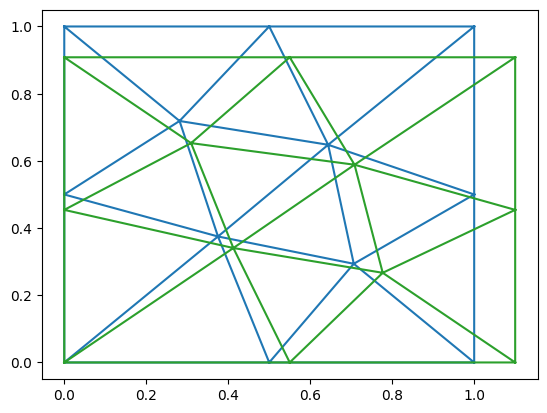

In [26]:
triplot(node_coords[:,0], node_coords[:,1], triangles=S_2)
triplot(curr_node_coords[:,0], curr_node_coords[:,1], triangles=S_2)

In [13]:
from dctkit.dec import vector as V
stress_tensor = V.DiscreteTensorFieldD(S=S, coeffs=stress.T, rank=2)
stress_integrated = V.flat_DPD(stress_tensor)
forces = C.star(stress_integrated)
forces.coeffs

Array([[-1.52152372e-05,  1.64656645e-06],
       [-1.92496856e-01, -1.44922099e-05],
       [-1.13097947e-01, -4.04147008e-07],
       [ 2.47211112e-05, -9.12724382e-06],
       [-1.92495073e-01, -2.23503127e-05],
       [-1.44356568e-01, -2.02313349e-06],
       [-1.36782609e-05, -1.19302508e-05],
       [ 1.92545147e-01,  1.51019411e-05],
       [ 1.35572075e-01,  1.66191883e-05],
       [ 1.92470807e-01,  1.27796092e-05],
       [ 1.19271812e-05,  1.84075722e-05],
       [ 1.08275606e-01,  2.64055798e-05],
       [-1.13087744e-01, -1.02612516e-05],
       [-1.44387330e-01, -1.58293011e-05],
       [ 4.81335236e-02,  2.56858197e-05],
       [-8.41897794e-02,  4.79392378e-06],
       [ 1.35565503e-01,  9.41319168e-06],
       [ 1.08259559e-01,  1.09906919e-05],
       [ 7.94073778e-02,  1.38013009e-05],
       [-5.69705108e-02,  1.05347335e-05],
       [-3.12955264e-02,  9.35841307e-06],
       [-1.36371929e-01, -6.49571127e-06],
       [-1.05072418e-01, -1.27903294e-06],
       [-1.

In [14]:
print(curr_node_coords)
node_coord_final = node_coords.copy()
node_coord_final[:,0] *= 1.1
print(node_coord_final)
print(np.sum((node_coord_final - curr_node_coords)**2))

[[ 1.09999999e+00  7.06596759e-05  0.00000000e+00]
 [ 1.08419340e-07  1.09239034e-07  0.00000000e+00]
 [ 1.09999996e+00  9.08338303e-01  0.00000000e+00]
 [-1.15002097e-08  9.08334252e-01  0.00000000e+00]
 [ 5.50002698e-01  4.48708385e-05  0.00000000e+00]
 [-6.96258338e-08  4.54164149e-01  0.00000000e+00]
 [ 5.49992322e-01  9.08335127e-01  0.00000000e+00]
 [ 1.09999997e+00  4.54210987e-01  0.00000000e+00]
 [ 7.76872198e-01  2.66868710e-01  0.00000000e+00]
 [ 4.12491186e-01  3.40641756e-01  0.00000000e+00]
 [ 7.08112607e-01  5.88545126e-01  0.00000000e+00]
 [ 3.09364983e-01  6.52871444e-01  0.00000000e+00]]
[[1.1        0.         0.        ]
 [0.         0.         0.        ]
 [1.1        1.         0.        ]
 [0.         1.         0.        ]
 [0.55       0.         0.        ]
 [0.         0.5        0.        ]
 [0.55       1.         0.        ]
 [1.1        0.5        0.        ]
 [0.776875   0.29375    0.        ]
 [0.4125     0.375      0.        ]
 [0.708125   0.64791667 0. 

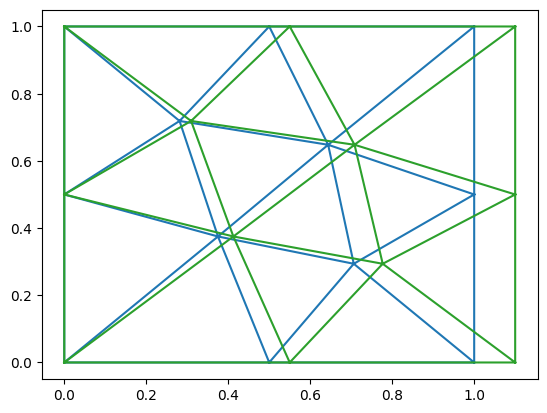

In [12]:
triplot(node_coords[:,0], node_coords[:,1], triangles=S_2)
triplot(node_coord_final[:,0], node_coord_final[:,1], triangles=S_2)

In [18]:
strain = ela.get_strain(node_coord_final)
stress = ela.get_stress(strain)
print(strain)
print(stress)

[[[ 1.05000000e-01 -6.96942505e-17]
  [-8.32667268e-17 -5.55111512e-17]]

 [[ 1.05000000e-01 -4.16333634e-17]
  [-5.55111512e-17  0.00000000e+00]]

 [[ 1.05000000e-01  1.22679644e-16]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 1.05000000e-01 -1.86790139e-17]
  [-9.57007362e-17 -5.55111512e-17]]

 [[ 1.05000000e-01 -5.52335959e-17]
  [-4.22231703e-17  1.11022302e-16]]

 [[ 1.05000000e-01 -1.79543880e-16]
  [ 6.93889390e-18 -5.55111512e-17]]

 [[ 1.05000000e-01  3.34732238e-17]
  [ 3.26128013e-17  0.00000000e+00]]

 [[ 1.05000000e-01 -1.19036725e-16]
  [-1.01307851e-16 -1.11022302e-16]]

 [[ 1.05000000e-01  2.55995543e-17]
  [-2.35922393e-17 -1.11022302e-16]]

 [[ 1.05000000e-01 -6.48529935e-17]
  [ 3.67761377e-17  0.00000000e+00]]

 [[ 1.05000000e-01  2.52407231e-17]
  [ 1.38777878e-17  0.00000000e+00]]

 [[ 1.05000000e-01  4.97379920e-17]
  [ 2.77555756e-17  2.22044605e-16]]

 [[ 1.05000000e-01 -5.46018960e-17]
  [-2.77555756e-17  1.66533454e-16]]

 [[ 1.05000000e-01  9.67692886e-17]
  